### **Descarga e importe de bibliotecas**

In [1]:
%%capture
# Instalar y actualizar bibliotecas necesarias
!pip install gdown
!pip install roboflow
!pip install ultralytics

# Importar bibliotecas a usar y deshabilitar WanDB
import os
import yaml
import gdown
import wandb
import shutil
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from roboflow import Roboflow
from ultralytics import YOLO


os.environ['WANDB_DISABLED'] = 'true'

### **Descarga y acondicionamiento de la base de datos de semillas**

In [2]:
# Descargar repositorio de aisladores
rf = Roboflow(api_key="9smAmQgaD8pNOTsDMYKR")
project = rf.workspace("mamitas").project("mamitas-yolo-2")
version = project.version(1)
dataset = version.download("yolov11")
!mkdir datasets
!mv ./MAMITAS-YOLO-2-1 ./datasets/

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MAMITAS-YOLO-2-1 in yolov11:: 100%|██████████| 844/844 [00:00<00:00, 7916.54it/s]


In [4]:
data = {
    'path': './MAMITAS-YOLO-2-1',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 1,
    'names': ['feet'],
    'roboflow': {
        'license': 'CC BY 4.0',
        'project': 'MAMITAS-YOLO-2-1',
        'url': 'https://universe.roboflow.com/mamitas/mamitas-yolo-2/dataset/1',
        'version': '1',
        'workspace': 'Mamitas'}
}

# Especificar el directorio del archivo
file_path = './datasets/MAMITAS-YOLO-2-1/data.yaml'

# Escribir la información sobre el archivo YAML
with open(file_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

### **Entrenamiento del modelo YOLOv11**

In [5]:
# Entrenar YOLOv11 para detección de mamitas

# Carga de modelo preentrenado
model = YOLO('yolo11m.pt')

# Entrenar el modelo
results = model.train(data='./datasets/MAMITAS-YOLO-2-1/data.yaml', epochs=100, imgsz=640, device=[0,1])

100%|██████████| 38.8M/38.8M [00:00<00:00, 225MB/s]
100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


### **Rendimiento del modelo sobre datos de validación**

val: Scanning /kaggle/working/datasets/MAMITAS-YOLO-2-1/valid/labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
invalid value encountered in less
invalid value encountered in less


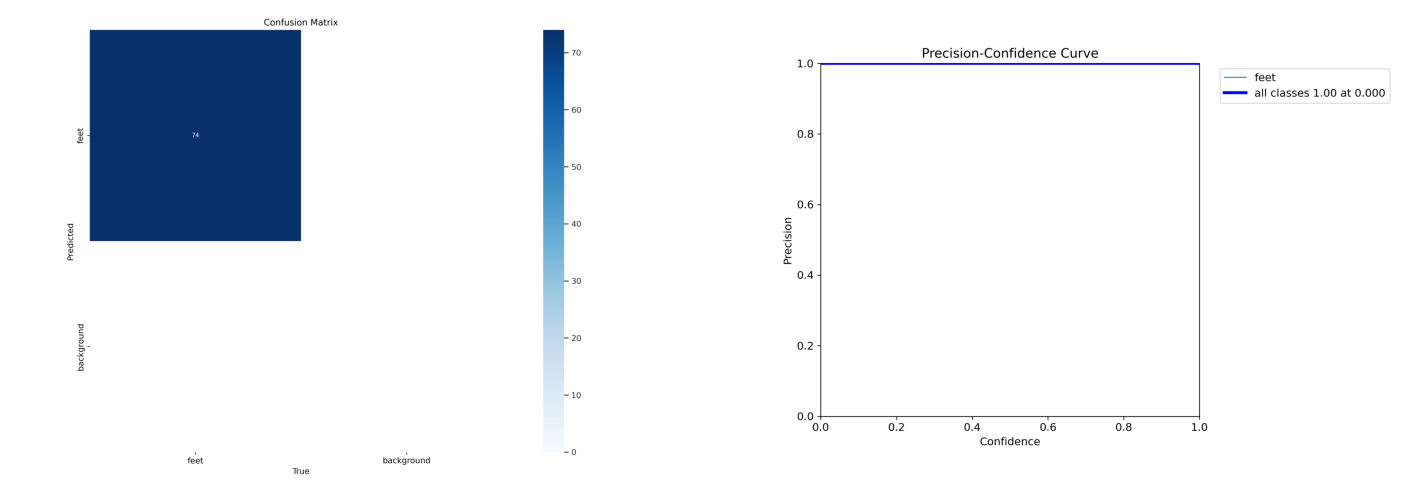

In [6]:
# Validar el modelo entrenado

# Carga de modelo entrenado
model = YOLO('./runs/detect/train/weights/best.pt') 

# Realizar validación
validation_results = model.val(data='./datasets/MAMITAS-YOLO-2-1/data.yaml',
                               imgsz=640,
                               batch=16,
                               conf=0.8,
                               iou=0.6,
                               device='0')

# Cargar la imagen
image = mpimg.imread("./runs/detect/val/confusion_matrix.png")
image_1 = mpimg.imread("./runs/detect/val/P_curve.png")

# Mostrar la matriz de confusión imagen
fig, axis = plt.subplots(1,2,figsize=(18,8))
axis[0].imshow(image)
axis[0].axis('off')
axis[1].imshow(image_1)
axis[1].axis('off')
plt.show()